In [2]:
import itertools
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

In [38]:
warnings.filterwarnings("ignore") # gereksiz uyarılar için 

In [39]:
data = pd.read_csv("airline-passengers.csv",index_col="month",parse_dates=True) # tarihleri datetime formatına aldık.

In [5]:
data.head()

,total_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [6]:
data.index.freq = "MS" #frekansı aylık olarak belirttik.

In [7]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq='MS')

In [42]:
data.isna().sum()

total_passengers    0
dtype: int64

<Axes: title={'center': 'TOPLAM YOLCU SAYISI'}, xlabel='month'>

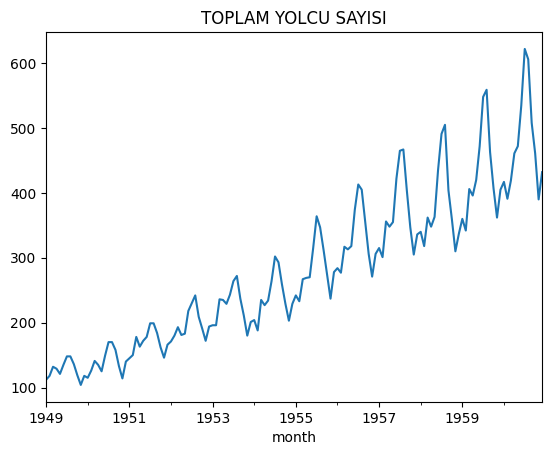

In [41]:
data["total_passengers"].plot(title="TOPLAM YOLCU SAYISI")

In [46]:
data.shape

(144, 1)

In [9]:
train = data[:120] # 120 tanesini train e attık.

In [10]:
test = data[120:] # 24 tanesi test için.

In [11]:
alphas = np.arange(0.01, 1, 0.10)

In [58]:
def ses_optimizer(train, alphas, step = 24):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test,y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("Alpha: ",round(alpha,2), "mae : ",round (mae,4))
    print("Best Alpha is : ",round(best_alpha,2), "Best mae :", round(best_mae,4))
    return best_alpha,best_mae

# en iyi alphayı bulmak için bir basit bir algoritma yazdık. 

In [13]:
best_ses_alpha, best_mae_ses = ses_optimizer(train,alphas)

# mae : 82.52

Alpha:  0.01 mae :  225.5863
Alpha:  0.11 mae :  82.528
Alpha:  0.21 mae :  82.8979
Alpha:  0.31 mae :  89.8377
Alpha:  0.41 mae :  99.0585
Alpha:  0.51 mae :  107.5558
Alpha:  0.61 mae :  113.7514
Alpha:  0.71 mae :  117.2224
Alpha:  0.81 mae :  118.1776
Alpha:  0.91 mae :  117.2438
Best Alpha is :  0.11 Best mae : 82.528


In [14]:
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_ses_alpha)
y_pred_ses = ses_model.forecast(24)

In [49]:
def plotlars(y_pred,title):
    train["total_passengers"].plot(legend=True,label="train")
    test["total_passengers"].plot(legend=True, label= "test")
    y_pred.plot(legend=True,label="Prediction")
    plt.title(title)
    plt.show()

# tek tek bakmak yerine görselleştirecek bir fonksiyon.

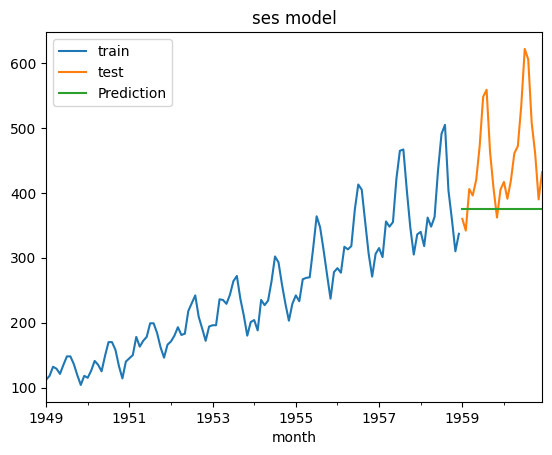

In [50]:
plotlars(y_pred_ses,"ses model") # ses sadece ortalamayı buldu.

## DES MODEL

In [51]:
def des_optimizer(train, alphas, betas, step = 24):
    best_alpha,best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            double_model = ExponentialSmoothing(train,trend="add").fit(smoothing_level=alpha, smoothing_trend=beta)
            y_pred = double_model.forecast(step)
            mae = mean_absolute_error(test,y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("Alpha: ",round(alpha,2), "Beta : ", round(beta,2), "mae : ",round (mae,4))
    print("Best Alpha is : ",round(best_alpha, 2), "Best beta :", round(best_beta, 2), "Best mae :", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

alphas = np.arange(0.01,1,0.10)
betas = np.arange(0.01,1,0.10)

# double exponential smoothing yöntemi için algoritma. 2 döngü gerekti beta da giriyor devreye çünkü.  

In [54]:
best_des_alpha, best_des_betas, best_mae_des = des_optimizer(train,alphas,betas)

# mae : 54.10

Alpha:  0.01 Beta :  0.01 mae :  54.9512
Alpha:  0.01 Beta :  0.11 mae :  54.1036
Alpha:  0.01 Beta :  0.21 mae :  55.5568
Alpha:  0.01 Beta :  0.31 mae :  57.3247
Alpha:  0.01 Beta :  0.41 mae :  57.7931
Alpha:  0.01 Beta :  0.51 mae :  57.9968
Alpha:  0.01 Beta :  0.61 mae :  57.9637
Alpha:  0.01 Beta :  0.71 mae :  57.5635
Alpha:  0.01 Beta :  0.81 mae :  57.3334
Alpha:  0.01 Beta :  0.91 mae :  57.8983
Alpha:  0.11 Beta :  0.01 mae :  55.0309
Alpha:  0.11 Beta :  0.11 mae :  58.4728
Alpha:  0.11 Beta :  0.21 mae :  69.6339
Alpha:  0.11 Beta :  0.31 mae :  72.555
Alpha:  0.11 Beta :  0.41 mae :  78.8168
Alpha:  0.11 Beta :  0.51 mae :  81.996
Alpha:  0.11 Beta :  0.61 mae :  77.2262
Alpha:  0.11 Beta :  0.71 mae :  71.5042
Alpha:  0.11 Beta :  0.81 mae :  69.0258
Alpha:  0.11 Beta :  0.91 mae :  67.8408
Alpha:  0.21 Beta :  0.01 mae :  57.1824
Alpha:  0.21 Beta :  0.11 mae :  74.992
Alpha:  0.21 Beta :  0.21 mae :  95.9492
Alpha:  0.21 Beta :  0.31 mae :  115.3164
Alpha:  0.21 Beta 

In [19]:
des_model = ExponentialSmoothing(train,trend="add").fit(smoothing_level=best_des_alpha,smoothing_trend=best_des_betas)

In [20]:
y_pred_des = des_model.forecast(24)

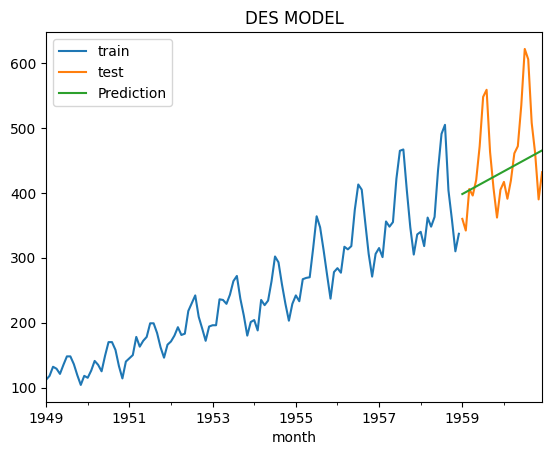

In [55]:
plotlars(y_pred_des,"DES MODEL") # trendi ve ortalamayı buldu ama yetmez.

## TES MODEL

In [22]:
alpha = beta = gamma = np.arange(0.01, 1, 0.10)
abg = list(itertools.product(alpha,beta,gamma))
dfabg = pd.DataFrame(itertools.product(alpha,beta,gamma))

def tes_optimizer(train, abg, step = 24):
    best_alpha,best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model_kardes = ExponentialSmoothing(train,trend="add",seasonal="add",seasonal_periods=12).fit(smoothing_level=comb[0], smoothing_trend=comb[1], smoothing_seasonal=comb[2])
        tes_y_pred = tes_model_kardes.forecast(step)
        mae = mean_absolute_error(test,tes_y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0],2),round(comb[1],2), round(comb[2],2), round(mae,4)])
    print("Best Alpha is : ",round(best_alpha, 2), "Best beta :", round(best_beta, 2), "Best gamma is : ",round(best_gamma,2), "Best mae :", round(best_mae, 4))
    return best_alpha, best_beta, best_gamma, best_mae

# triple exponential smoothing yöntemi için algoritma. abg 3 defa iç içe fonksiyonla uğraşmıyalım diye var. Bütün kombinasyonlar itertools ile ona atadık.

In [56]:
best_tes_alphas, best_tes_betas, best_tes_gamma, best_mae_tes= tes_optimizer(train,abg);

# MAE : 8.38

[np.float64(0.01), np.float64(0.01), np.float64(0.01), np.float64(34.6485)]
[np.float64(0.01), np.float64(0.01), np.float64(0.11), np.float64(32.5693)]
[np.float64(0.01), np.float64(0.01), np.float64(0.21), np.float64(28.9892)]
[np.float64(0.01), np.float64(0.01), np.float64(0.31), np.float64(26.52)]
[np.float64(0.01), np.float64(0.01), np.float64(0.41), np.float64(25.2756)]
[np.float64(0.01), np.float64(0.01), np.float64(0.51), np.float64(24.6981)]
[np.float64(0.01), np.float64(0.01), np.float64(0.61), np.float64(24.7203)]
[np.float64(0.01), np.float64(0.01), np.float64(0.71), np.float64(25.2396)]
[np.float64(0.01), np.float64(0.01), np.float64(0.81), np.float64(26.1484)]
[np.float64(0.01), np.float64(0.01), np.float64(0.91), np.float64(27.3483)]
[np.float64(0.01), np.float64(0.11), np.float64(0.01), np.float64(31.9795)]
[np.float64(0.01), np.float64(0.11), np.float64(0.11), np.float64(29.9107)]
[np.float64(0.01), np.float64(0.11), np.float64(0.21), np.float64(26.1929)]
[np.float64(0.

In [24]:
tes_model = ExponentialSmoothing(train,trend="add",seasonal="add",seasonal_periods=12).fit(smoothing_level=best_tes_alphas,
                                                                                            smoothing_trend=best_tes_betas,
                                                                                            smoothing_seasonal=best_tes_gamma)

In [25]:
y_pred_tes = tes_model.forecast(24)

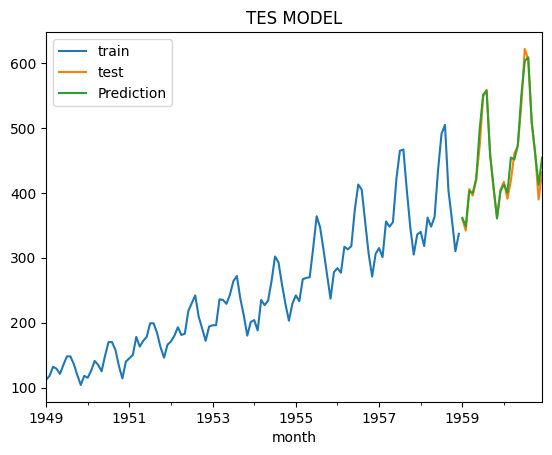

In [57]:
plotlars(y_pred_tes,"TES MODEL") # ve mevsimselliği de yakalıyoruz.

## SARIMA MODEL

In [27]:
def sarima_optimizer(train, pdq, seasonal_pdq,display=False):
    best_aic, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarima_model = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit(disp=0)
                aic = sarima_model.aic
                if aic < best_aic:
                    best_aic, best_order, best_seasonal_order = aic, param, param_seasonal
                print('SARIMA{}x{}12 - AIC : {}'.format(param, param_seasonal, aic))
            except:
                continue
    print('Best SARIMA{}x{}12 - AIC : {}'.format(best_order, best_seasonal_order, best_aic))
    return best_order, best_seasonal_order


p = d = q = range(0,2)
pdq=list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],12) for x in list(itertools.product(p,d,q))]

# sarima optimizer. Sarıma modelinin matematiğini iyi anlamak lazım.

In [28]:
best_order, best_seasonal_order = sarima_optimizer(train,pdq,seasonal_pdq,display=True)

SARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC : 1680.2792351899682
SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC : 1557.6320531158312
SARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC : 1060.4792883429307
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC : 1014.0696747520262
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC : 1231.9865853758386
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC : 1185.301097909056
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC : 969.3781382611883
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC : 951.6074014199974
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC : 1524.3620853403545
SARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC : 1403.5942348893623
SARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC : 967.5225695583002
SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC : 942.2425093046857
SARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC : 1136.4998829523724
SARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC : 1127.8397002701709
SARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC : 918.2233876024418
SARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC : 896.7289215560032
SARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC : 1138.8088994229304
SARI

In [29]:
sarima_model = SARIMAX(train,order=best_order, seasonal_order=best_seasonal_order).fit(disp=0)
y_pred_sarima = sarima_model.forecast(24)
y_pred_sarima = pd.Series(y_pred_sarima, index=test.index)

mean_absolute_error(test,y_pred_sarima);

# MAE : 68.57

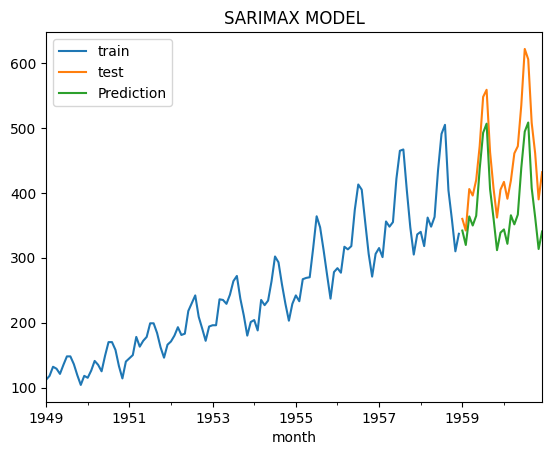

In [30]:
plotlars(y_pred_sarima,"SARIMAX MODEL") # tes modeli kadar iyi değil ama mevsimselliği yakaladı.

## EN İYİ MODEL

In [31]:
FİNAL_model = ExponentialSmoothing(data,trend="add",seasonal="add",seasonal_periods=12).fit(smoothing_level=best_tes_alphas,
                                                                                            smoothing_trend=best_tes_betas,
                                                                                            smoothing_seasonal=best_tes_gamma)

In [36]:
mean_absolute_error(test,y_pred_tes)

np.float64(8.381671466731754)

In [59]:
final_pred = FİNAL_model.forecast(4)
final_pred # 1960-12 den itibaren sonraki ayların tahmini yolcu sayısı. PROJE BU KADARDI TEŞEKKÜRLER

1961-01-01    445.323694
1961-02-01    415.977714
1961-03-01    450.731535
1961-04-01    483.252157
Freq: MS, dtype: float64